# 0. Imports

In this section, necessary libraries are imported.

In [ ]:
import pandas as pd
import numpy as np

import gensim
from gensim.parsing.preprocessing import STOPWORDS

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import re

# 1. Data 

In this section, the data is loaded in, cleaned, and visualized.

## 1.a Data Introduction

For this project, we have gathered post data from 4 different race/ethnicity related subreddits. This includes r/asianamerican, r/blackpeople, r/whitepeople, and r/NativeAmerican. [MENTION HOW MANY POSTS ARE DOWNLOADED FOR EACH SUBREDDIT]. The data is retrieved in a json file format. Each json file is loaded into an individual pandas dataframe for each subreddit below.

In [ ]:
asian = pd.read_json("/DATA/asian.json")
black = pd.read_json("/DATA/blackPeople.json")
white = pd.read_json("/DATA/whitePeople.json")
native = pd.read_json("/DATA/nativeAmerican.json")

Below, the json files are converted to a csv format and then the pandas dataframes are updated with the respective CSV files.

In [ ]:
def convert_json(data, path, filename):
  data.to_csv(path+'/'+filename+'.csv', index=False)

In [ ]:
path = '/DATA'
convert_json(asian,path,'asian')
convert_json(black,path,'blackPeople')
convert_json(white,path,'whitePeople')
convert_json(native,path,'nativeAmerican')

In [ ]:
asian = pd.read_csv("/DATA/Processed/asian.csv")
black = pd.read_csv("/DATA/Processed/blackPeople.csv")
white = pd.read_csv("/DATA/Processed/whitePeople.csv")
native = pd.read_csv("/DATA/Processed/nativeAmerican.csv")

In the cell below, the **body** column of the asian pandas dataframe is printed. We can observe some text examples in the entries that are shown and that there are 100,393 entries in the dataframe.

In [ ]:
print(asian['body'].head)

<bound method NDFrame.head of 0         &gt; But retirement is a privilege, often one ...
1         Singaporean authorities won’t bother you if yo...
2                                             Who’s ”they”?
3         I’ve been called paranoid for bringing this up...
4         I live in the west. We definitely post about this
                                ...                        
100389    The wonders of Raya The Last Dragon, where all...
100390    Not exactly the best representation with a fat...
100391    There are Chinese gangs in the San Francisco C...
100392    You’d like Past Lives, saw it at Sundance and ...
100393    Oh yeah he’s also in this one show called Regi...
Name: body, Length: 100394, dtype: object>


## 1.b Data Cleaning

The cell below defines a function for cleaning the data. This process includes removing a variety of special characters, removing columns with empty entries, and stripping empty spaces from the beginning and end of each entry. 

In [ ]:
def clean_data(df, column):

  new_column = 'cleaned_body'
  df[new_column] = df.loc[:, column]

  spec_chars = ["!",'"',"#","%","&","'","(",")",
                "*","+",",","-","/",".",":",";","<",
                "=",">","?","@","[","\\","]","^","_",
                "`","{","|","}","~","–"]
                
  for char in spec_chars:
      df[new_column] = df[new_column].str.replace(char, '')

  df[new_column]=df[new_column].str.encode("ascii", "ignore")
  df[new_column]=df[new_column].str.decode("utf-8")

  r = ['NA']
  r1 = ['deleted']
  r2 = ['removed']

  df = df[~df[new_column].isin(r)]
  df = df[~df[new_column].isin(r1)]
  df = df[~df[new_column].isin(r2)]

  df[new_column].replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)
  df[new_column]=df[new_column].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

  df[new_column] = df[new_column].str.strip()

  empty = df[(df[new_column].isnull())].index
  df.drop(empty, inplace=True)

  nan_value = float("NaN")
  df.replace("", nan_value, inplace=True)

  df.dropna(subset=new_column, inplace=True)

  df.reset_index(inplace=True, drop = True)

  return df

The function below joins all of the words in each entry of the body column into a respective list. This allows each entry of the body column to be a list of words.

In [ ]:
def process_text(data):
  text = " ".join(txt for txt in data.body)
  return text

Below, the clean_data function is used on each dataframe.

In [ ]:
asian = clean_data(asian, 'body')
black = clean_data(black, 'body')
white = clean_data(white, 'body')
native = clean_data(native, 'body')

<ipython-input-15-90c1089f5e04>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[new_column] = df[new_column].str.replace(char, '')
<ipython-input-15-90c1089f5e04>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[new_column] = df[new_column].str.replace(char, '')
<ipython-input-15-90c1089f5e04>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[new_column] = df[new_column].str.replace(char, '')
<ipython-input-15-90c1089f5e04>:12: FutureWarning: The default value of regex will change from True to False in a futu

Here we can see examples of entries with special characters removed from using the clean_data function. However, the entries still contain stop words that will not be helpful for our task.

In [ ]:
print(black['cleaned_body'][50:70])

50    At least two of his kids dont have to worry ab...
51    No But I had friends I a ton of time with and ...
52    Rule 1 This is a sub for the black community t...
53                                                  Yes
54    I voluntarily signed for myself out of highsch...
55    All of this And hugs were never really a thing...
56    Nope Not as a kid   Later on when I was an adu...
57    Im starting to think that the majority of ppl ...
58    So basically the EWF an American organization ...
59    Nick Canon is trying to promote animal husband...
60                                      Great interview
61    So firstly there is a distinction between conc...
62                                This ALL of this THIS
63    why more Native Americans died and we are not ...
64    Memphis is the 26th most dangerous city in the...
65           I could absolutely do that Ill message you
66    gtbut they were allowed to at least exist unde...
67    I figured I do not live anywhere near Memp

Below, the process_text function is used on each dataframe to convert each entry into a list of words.

In [ ]:
asian_words = process_text(asian)
black_words = process_text(black)
white_words = process_text(white)
native_words = process_text(native)

## 1.c Data Visualization

In the below cells, we set the stop words based on the set we imported at the beginning of this notebook. We then define a generate_cloud function that will create a wordcloud for each dataframe and exclude stop words. This will allow us to see the most relevant terms anf phrases for each subreddit.

In [ ]:
stopwords = set(STOPWORDS)

In [ ]:
def generate_cloud(words):
  word_cloud = WordCloud(width = 1500, height = 1500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 8).generate(words)
  return word_cloud

Here the generate_cloud function is used on each dataframe and assigned to a respective variable.

In [ ]:
asian_wordcloud = generate_cloud(asian_words)
black_wordcloud = generate_cloud(black_words)
white_wordcloud = generate_cloud(white_words)
native_wordcloud = generate_cloud(native_words)

In [ ]:
def plot_wordClouds(wordcloud, title):
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.title(title)
  plt.imshow(wordcloud)
  plt.axis("on")
  plt.tight_layout(pad = 0)
  plt.savefig(title+'.png', dpi=300, bbox_inches='tight')
  plt.show()

Below we have visualized each wordcloud. [MAKE OBSRVATIONS]

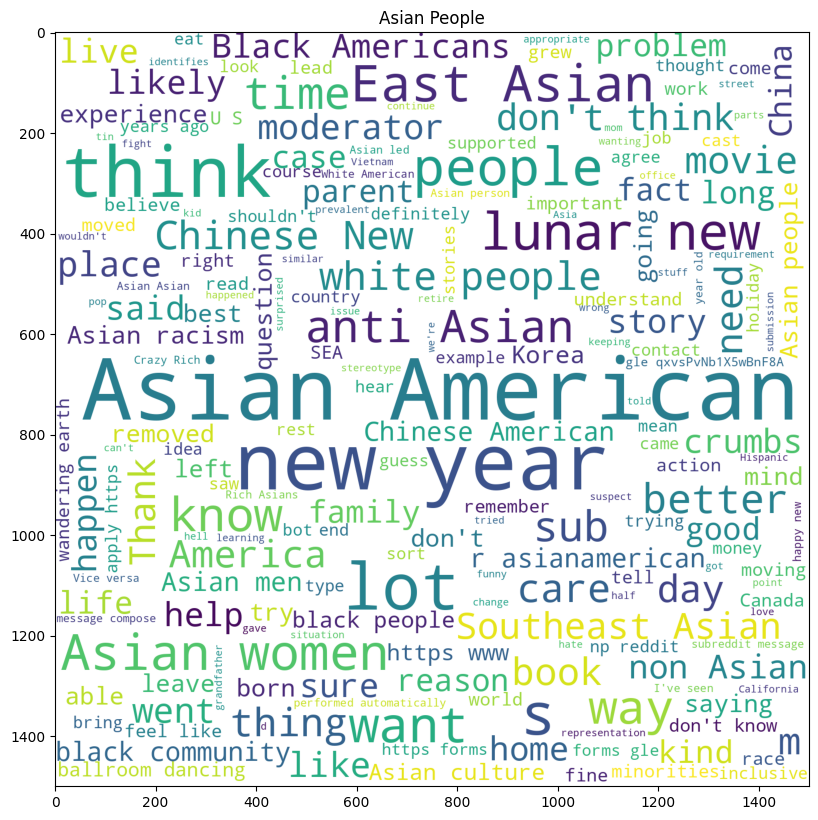

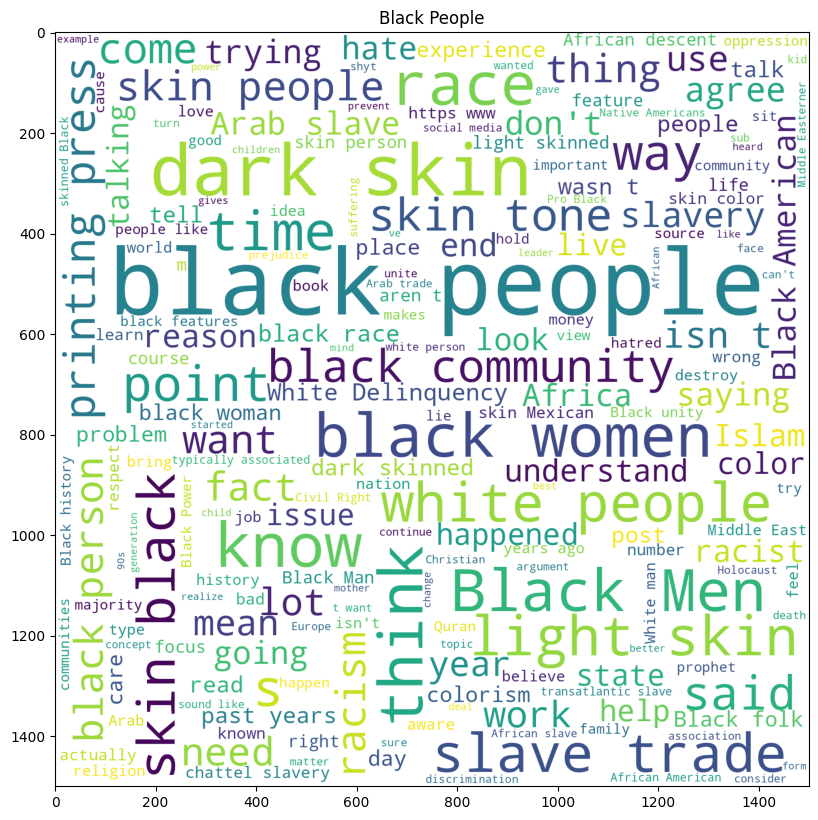

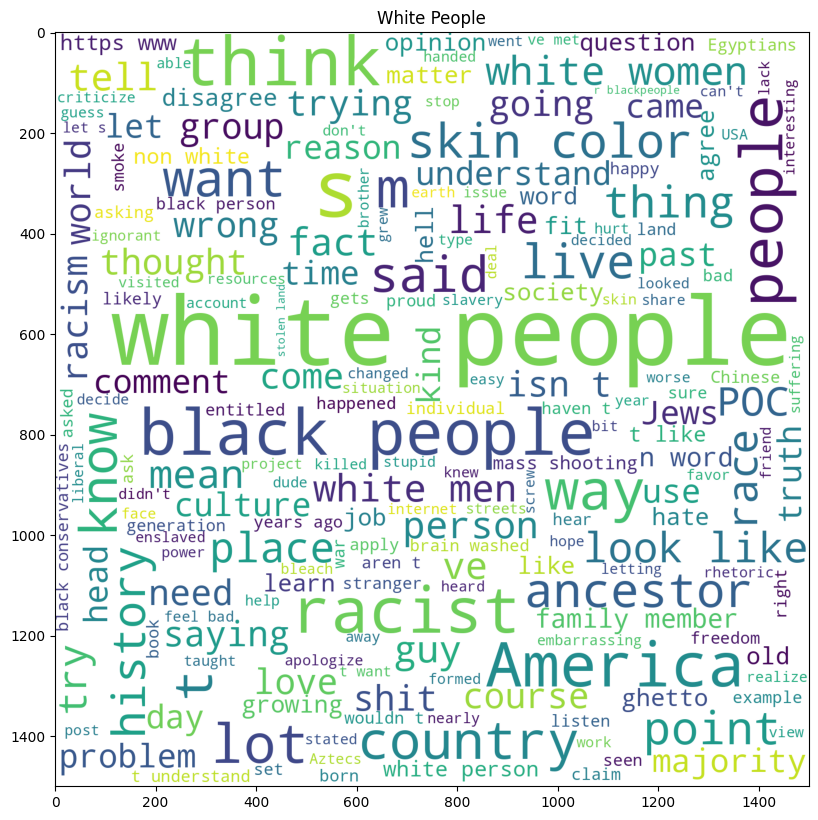

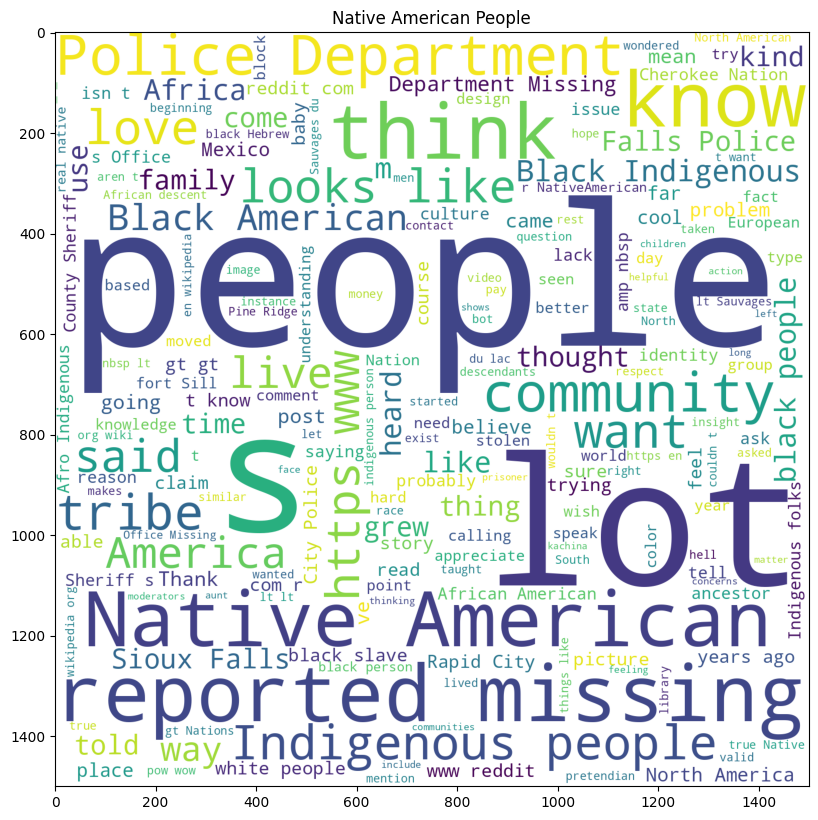

In [ ]:
# Visualizing word clouds
plot_wordClouds(asian_wordcloud, 'Asian People')
plot_wordClouds(black_wordcloud, 'Black People')
plot_wordClouds(white_wordcloud, 'White People')
plot_wordClouds(native_wordcloud, 'Native American People')

Below a race column is created in order to label the data, since the dataframes will eventually be combined.

In [ ]:
# Labeling the data

asian['race'] = 'Asian'
black['race'] = 'Black'
white['race'] = 'White'
native['race'] = 'Native American'

In [ ]:
print(asian['author'].nunique())

238


In the below cell, we can observe all column names of the asian dataset. However, only a few of these will be important for our research.

In [ ]:
print(asian.columns)
#print(asian['author'])

Index(['subreddit_id', 'author_is_blocked', 'comment_type', 'edited',
       'author_flair_type', 'total_awards_received', 'subreddit',
       'author_flair_template_id', 'id', 'gilded', 'archived',
       'collapsed_reason_code', 'no_follow', 'author', 'send_replies',
       'parent_id', 'score', 'author_fullname', 'all_awardings', 'body',
       'top_awarded_type', 'author_flair_css_class', 'author_patreon_flair',
       'collapsed', 'author_flair_richtext', 'is_submitter', 'gildings',
       'collapsed_reason', 'associated_award', 'stickied', 'author_premium',
       'can_gild', 'link_id', 'unrepliable_reason', 'author_flair_text_color',
       'score_hidden', 'permalink', 'subreddit_type', 'locked',
       'author_flair_text', 'treatment_tags', 'created_utc',
       'subreddit_name_prefixed', 'controversiality',
       'author_flair_background_color', 'collapsed_because_crowd_control',
       'distinguished', 'retrieved_utc', 'updated_utc', 'body_sha1',
       'nest_level', 'utc_da

Below, only the id, author, body, cleaned_body, and race columns are extracted from each dataframe. Then the 4 dataframes are combined into one dataframe and the index for this dataframe is reset.

In [ ]:
asian = asian[['subreddit_id', 'author', 'body', 'cleaned_body', 'race']]
black = black[['subreddit_id', 'author', 'body', 'cleaned_body', 'race']]
white = white[['subreddit_id', 'author', 'body', 'cleaned_body', 'race']]
native = native[['subreddit_id', 'author', 'body', 'cleaned_body', 'race']]

temp = asian.append(black)
temp1 = temp.append(white)
data = temp1.append(native)

data.reset_index(inplace=True, drop=True)

<ipython-input-28-4da76ec984b0>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = asian.append(black)
<ipython-input-28-4da76ec984b0>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp1 = temp.append(white)
<ipython-input-28-4da76ec984b0>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = temp1.append(native)


Below is an example of the body and cleaned_body column of a particular entry. The body column contains the raw data from the json file and the cleaned_body column contains the body after pre-processing. 

In [ ]:
print(asian['body'][353])
print(data['cleaned_body'][353])

I find that cracks and crumbs are fine as long as you spread them over vanilla ice cream!
I find that cracks and crumbs are fine as long as you spread them over vanilla ice cream


Below we can observe the number of entries for each indiviual dataframe as well as the number of entries for the combined dataframe. We can see that we have a very balanced amount of each class.

In [ ]:
print(len(asian))
print(len(white))
print(len(black))
print(len(native))
print(len(data))

93324
98490
94068
97284
383166


In [ ]:
print(black['body'][50:70])

50    At least two of his kids don’t have to worry a...
51    No. But I had friends I a ton of time with and...
52    Rule #1. This is a sub for the black community...
53                                                 Yes.
54    I voluntarily signed for myself out of high-sc...
55    All of this. And hugs were never really a thin...
56    Nope. Not as a kid\n\n\nLater on when I was an...
57    I’m starting to think that the majority of ppl...
58    So basically the EWF an American organization ...
59    Nick Canon is trying to promote animal husband...
60                                   Great interview...
61    So firstly, there is a distinction between con...
62                             This! ALL of this! THIS!
63    why? more Native Americans died, and we are no...
64    Memphis is the 26th most dangerous city in the...
65        I could absolutely do that! I’ll message you!
66    &gt;but they were allowed to at least exist un...
67    I figured... I do not live anywhere near M

Below, the pre-processed versions of the data from each individual class, as well as a file with data from all classes combined, is saved in a CSV file.

In [ ]:
asian.to_csv("/DATA/Processed/asian.csv", index=False)
black.to_csv("/DATA/Processed/blackPeople.csv", index=False)
white.to_csv("/DATA/Processed/whitePeople.csv", index=False)
native.to_csv("/DATA/Processed/nativeAmerican.csv", index=False)

data.to_csv("/DATA/Processed/race.csv", index=False)

In this cell, we print the length of the combined dataframe. With all classes combined we have 383,166 entries.


In [ ]:
print(len(data))

383166
